# ASS#5 — LSTM with Attention (AAPL Close Prediction) and Conv Autoencoder (MNIST)

This notebook contains two tasks implemented in PyTorch and is Colab-ready.

- Q1: Stock Price Prediction using LSTM + Attention on AAPL Close price (2020-01-01 → 2023-01-01).
- Q2: Image Compression using a Convolutional Autoencoder on MNIST.

Notes:
- Run this in Google Colab for GPU acceleration. The first code cell installs required packages.
- For quick smoke tests, the notebook uses small epoch values; increase epochs for better performance.
- The notebook saves model checkpoints, scalers, and sample figures.


In [1]:
# Cell: Setup, imports, AAPL data download, preprocessing, Dataset, LSTMAttention, training utilities
# Install (Colab-safe) — uncomment in Colab if needed
# !pip install yfinance --quiet
# !pip install --quiet scikit-learn

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# -----------------------------
# 1) Fetch AAPL data
# -----------------------------
start_date = '2020-01-01'
end_date = '2023-01-01'
print('Downloading AAPL data...')
aapl = yf.download('AAPL', start=start_date, end=end_date)
print(aapl.shape)
print(aapl.head())

aapl.to_csv('AAPL_close_2020_2023.csv')

# Use Close prices
close = aapl['Close'].values.reshape(-1, 1)

# -----------------------------
# 2) Preprocessing and sequences
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(close)

def create_sequences(data, seq_len=60):
    xs = []
    ys = []
    for i in range(len(data) - seq_len):
        x = data[i:(i + seq_len)]
        y = data[i + seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 60
X, y = create_sequences(close_scaled, seq_len=SEQ_LEN)
print('Sequences:', X.shape, y.shape)

# Time-based split: train/val/test
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print('Train/Val/Test sizes:', X_train.shape[0], X_val.shape[0], X_test.shape[0])

# -----------------------------
# 3) PyTorch Dataset & DataLoader
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 4) LSTMAttention model
# -----------------------------
class LSTMAttention(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        # attention score: map hidden state -> scalar score
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attn=False):
        # x: (batch, seq_len, input_size)
        H, _ = self.lstm(x)  # H: (batch, seq_len, hidden_size)
        # compute scores
        scores = self.attn(H).squeeze(-1)  # (batch, seq_len)
        weights = torch.softmax(scores, dim=1)  # (batch, seq_len)
        # context: weighted sum of H along time
        # weights.unsqueeze(1): (batch, 1, seq_len)
        # H: (batch, seq_len, hidden_size)
        context = torch.bmm(weights.unsqueeze(1), H).squeeze(1)  # (batch, hidden_size)
        context = self.dropout(context)
        out = self.fc(context)  # (batch, 1)
        if return_attn:
            return out, weights
        return out

# quick model sanity check
model = LSTMAttention(input_size=1, hidden_size=64).to(device)
print('Model params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

# -----------------------------
# 5) Training utilities
# -----------------------------
def train_one_epoch(model, loader, optimizer, criterion, clip=1.0):
    model.train()
    epoch_loss = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    return epoch_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_total = 0
    preds_all = []
    trues_all = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        loss_total += loss.item() * xb.size(0)
        preds_all.append(preds.cpu().numpy())
        trues_all.append(yb.cpu().numpy())
    preds_all = np.vstack(preds_all)
    trues_all = np.vstack(trues_all)
    return loss_total / len(loader.dataset), preds_all, trues_all

# -----------------------------
# 6) Train the model (quick test)
# -----------------------------
EPOCHS = 20  # increase for real runs
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val = float('inf')
best_state = None
patience = 5
counter = 0
train_losses = []
val_losses = []
start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}/{EPOCHS}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping')
            break

print('Training done in {:.1f}s'.format(time.time() - start_time))
# save best model
if best_state is not None:
    torch.save({'model_state': best_state, 'scaler': scaler}, 'lstm_attn_best.pth')
    print('Saved lstm_attn_best.pth')
else:
    torch.save({'model_state': model.state_dict(), 'scaler': scaler}, 'lstm_attn_last.pth')

print('Now run the next cell to evaluate on test set and visualize predictions and attention weights.')


Device: cuda


/tmp/ipython-input-2605193660.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download('AAPL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


(756, 5)
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.468277  72.528597  71.223274  71.476615  135480400
2020-01-03  71.763718  72.523746  71.539330  71.696160  146322800
2020-01-06  72.335556  72.374162  70.634539  70.885472  118387200
2020-01-07  71.995361  72.600968  71.775796  72.345212  108872000
2020-01-08  73.153511  73.455110  71.698596  71.698596  132079200
Sequences: (696, 60, 1) (696, 1)
Train/Val/Test sizes: 487 104 105
Model params: 17282
Epoch 1/20, Train Loss: 0.211843, Val Loss: 0.168692
Epoch 2/20, Train Loss: 0.049822, Val Loss: 0.030333
Epoch 3/20, Train Loss: 0.031745, Val Loss: 0.013763
Epoch 4/20, Train Loss: 0.024102, Val Loss: 0.013968
Epoch 5/20, Train Loss: 0.016206, Val Loss: 0.008712
Epoch 6/20, Train Loss: 0.009325, Val Loss: 0.011998
Epoch 7/20, Train Loss: 0.008655, Val Loss: 0.026794
Epoch


=== Test Metrics (numeric) ===
Number of test samples: 105
RMSE: 16.2462
MAE:  14.5504
MSE (scaled): 0.017164

First few predictions vs actuals:
    Actual  Predicted
163.163300 148.365402
162.848999 148.337402
162.622803 148.423706
162.150696 148.509995
162.199905 148.742905
166.448593 149.051102
165.710999 149.317596
169.261505 149.632095


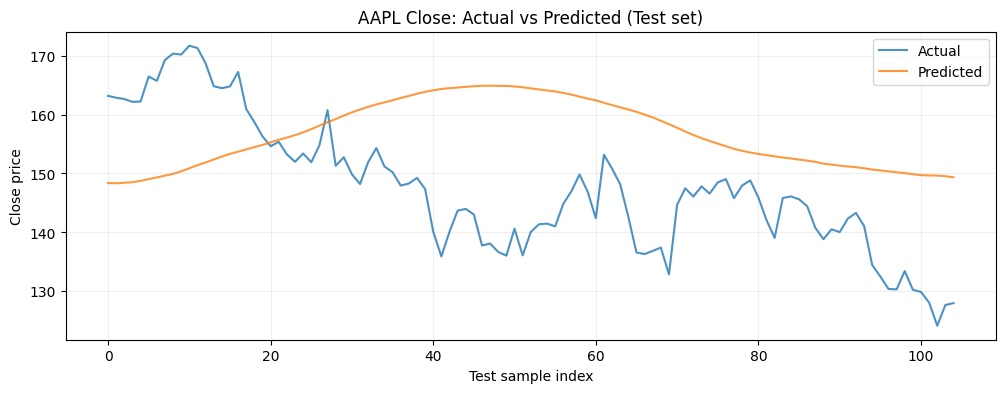

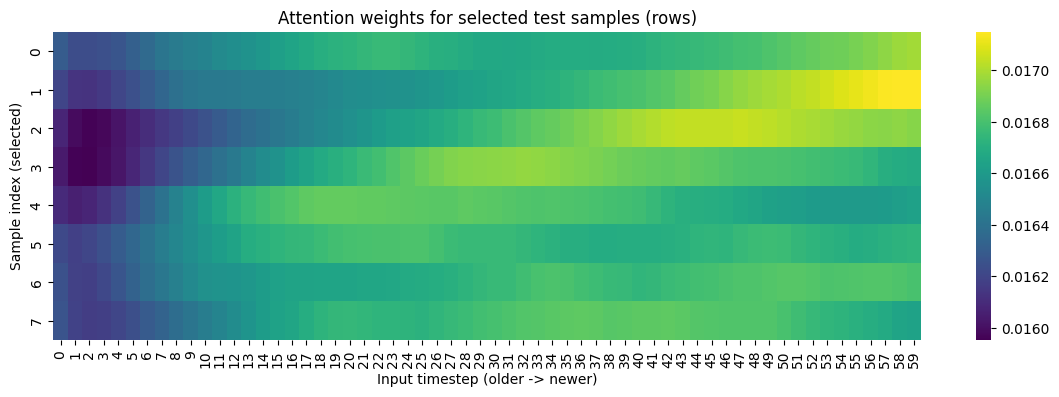

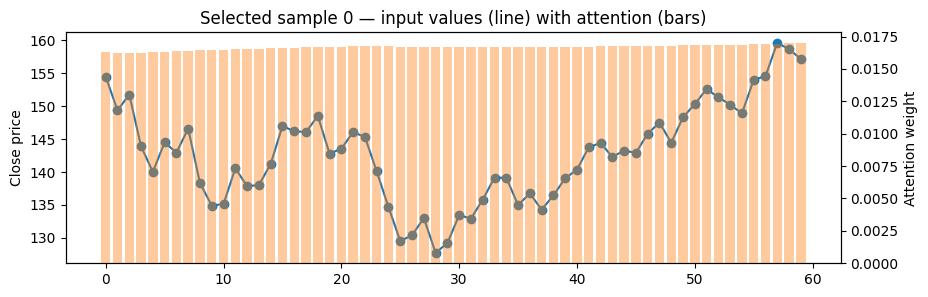


Top attention timesteps (per selected sample):
Sample 0: top timesteps (relative indices) -> [59, 58, 57]
Sample 14: top timesteps (relative indices) -> [58, 59, 57]
Sample 29: top timesteps (relative indices) -> [47, 46, 48]
Sample 44: top timesteps (relative indices) -> [32, 33, 31]
Sample 59: top timesteps (relative indices) -> [19, 20, 18]
Sample 74: top timesteps (relative indices) -> [24, 25, 23]
Sample 89: top timesteps (relative indices) -> [51, 50, 52]
Sample 104: top timesteps (relative indices) -> [36, 42, 41]

Attention visualization complete.


In [8]:
# Cell: Evaluate on test set and visualize predictions and attention (improved visuals + textual outputs)
import matplotlib.dates as mdates
import pickle
import seaborn as sns
from torch.serialization import add_safe_globals

# load best model robustly (model-only checkpoint + separate scaler.pkl)
model_loaded = False
try:
    ckpt = torch.load('lstm_attn_best.pth', map_location=device)
    if isinstance(ckpt, dict) and 'model_state' in ckpt:
        model.load_state_dict(ckpt['model_state'])
    else:
        model.load_state_dict(ckpt)
    model.to(device)
    model_loaded = True
    try:
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
    except FileNotFoundError:
        # fallback: try to extract scaler embedded in old checkpoint (not recommended)
        try:
            import sklearn.preprocessing._data as _skdata
            add_safe_globals([_skdata.MinMaxScaler])
        except Exception:
            pass
        try:
            ckpt_full = torch.load('lstm_attn_best.pth', map_location=device, weights_only=False)
            if isinstance(ckpt_full, dict) and 'scaler' in ckpt_full:
                scaler = ckpt_full['scaler']
                print('Loaded scaler from checkpoint.')
        except Exception:
            print('Could not load scaler from checkpoint; ensure scaler.pkl exists for reliable loading.')
except Exception as e:
    print('Initial torch.load failed (attempting permissive load). Error:', e)
    ckpt_full = torch.load('lstm_attn_best.pth', map_location=device, weights_only=False)
    if isinstance(ckpt_full, dict) and 'model_state' in ckpt_full:
        model.load_state_dict(ckpt_full['model_state'])
        if 'scaler' in ckpt_full:
            scaler = ckpt_full['scaler']
    else:
        model.load_state_dict(ckpt_full)
    model.to(device)
    model_loaded = True

if not model_loaded:
    raise RuntimeError('Failed to load model checkpoint. Check the file and try again.')

# Evaluate on test set
test_loss, preds_scaled, trues_scaled = evaluate(model, test_loader, criterion)
preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(-1)
trues = scaler.inverse_transform(trues_scaled.reshape(-1, 1)).reshape(-1)

rmse = math.sqrt(mean_squared_error(trues, preds))
mae = mean_absolute_error(trues, preds)
print('\n=== Test Metrics (numeric) ===')
print(f'Number of test samples: {len(trues)}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')
print(f'MSE (scaled): {test_loss:.6f}')

# Show a small table of the first 8 predictions vs actuals for quick inspection
import pandas as pd
n_show_table = min(8, len(trues))
tab = pd.DataFrame({'Actual': np.round(trues[:n_show_table], 4), 'Predicted': np.round(preds[:n_show_table], 4)})
print('\nFirst few predictions vs actuals:')
print(tab.to_string(index=False))

# Plot predicted vs actual summary (entire test set)
plt.figure(figsize=(12,4))
plt.plot(trues, label='Actual', alpha=0.8)
plt.plot(preds, label='Predicted', alpha=0.8)
plt.title('AAPL Close: Actual vs Predicted (Test set)')
plt.xlabel('Test sample index')
plt.ylabel('Close price')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Efficient attention visualization:
# Select a small set of representative test indices (uniformly spaced)
n_show = 8
idxs = np.linspace(0, len(X_test)-1, n_show, dtype=int)
X_batch = torch.tensor(X_test[idxs], dtype=torch.float32).to(device)  # (batch, seq_len, 1)
with torch.no_grad():
    outs, attn_batch = model(X_batch, return_attn=True)
attn_batch = attn_batch.detach().cpu().numpy()  # (batch, seq_len)

# Heatmap: rows = samples, cols = timesteps
plt.figure(figsize=(14, 4))
ax = sns.heatmap(attn_batch, cmap='viridis', cbar=True)
ax.set_xlabel('Input timestep (older -> newer)')
ax.set_ylabel('Sample index (selected)')
ax.set_title('Attention weights for selected test samples (rows)')
plt.show()

# For the first selected sample, overlay attention over the input values for interpretability
sample_idx = idxs[0]
x_vals = scaler.inverse_transform(X_test[sample_idx].reshape(-1,1)).ravel()
attn_vals = attn_batch[0]
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.plot(x_vals, '-o', color='tab:blue')
ax1.set_ylabel('Close price')
ax2 = ax1.twinx()
ax2.bar(np.arange(len(attn_vals)), attn_vals, alpha=0.4, color='tab:orange')
ax2.set_ylabel('Attention weight')
plt.title(f'Selected sample {sample_idx} — input values (line) with attention (bars)')
plt.show()

# Print most-attended timesteps for each sample (top 3)
print('\nTop attention timesteps (per selected sample):')
for i, idx in enumerate(idxs):
    top_k = np.argsort(-attn_batch[i])[:3]
    print(f'Sample {idx}: top timesteps (relative indices) ->', top_k.tolist())

print('\nAttention visualization complete.')


AE params: 111521
AE Epoch 1/10, Train MSE: 0.041931, Val MSE: 0.013581
AE Epoch 2/10, Train MSE: 0.010836, Val MSE: 0.008618
AE Epoch 3/10, Train MSE: 0.008111, Val MSE: 0.007269
AE Epoch 4/10, Train MSE: 0.007152, Val MSE: 0.006630
AE Epoch 5/10, Train MSE: 0.006627, Val MSE: 0.006238
AE Epoch 6/10, Train MSE: 0.006267, Val MSE: 0.005944
AE Epoch 7/10, Train MSE: 0.005993, Val MSE: 0.005765
AE Epoch 8/10, Train MSE: 0.005796, Val MSE: 0.005578
AE Epoch 9/10, Train MSE: 0.005620, Val MSE: 0.005439
AE Epoch 10/10, Train MSE: 0.005468, Val MSE: 0.005290


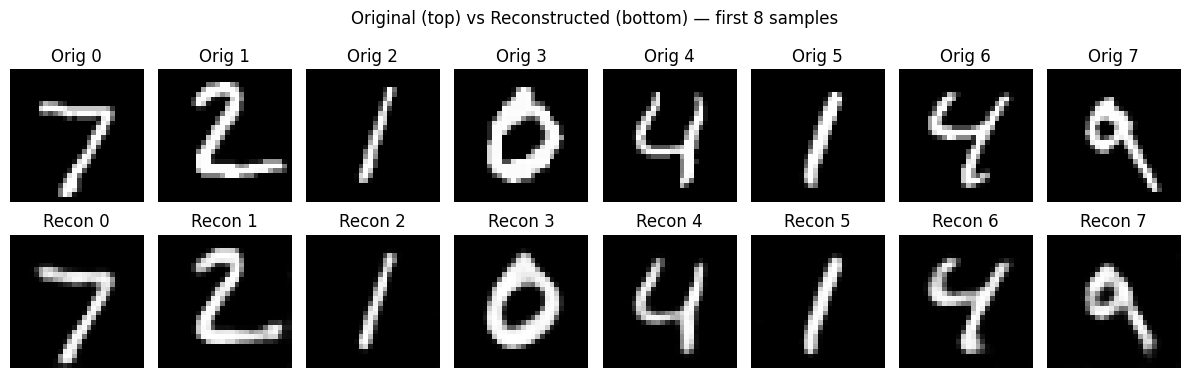


AE Test pixel MSE: 0.00528983, PSNR: 22.7656 dB


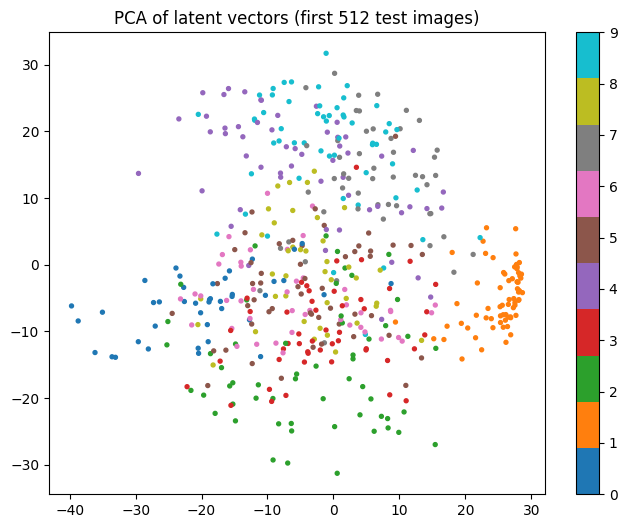

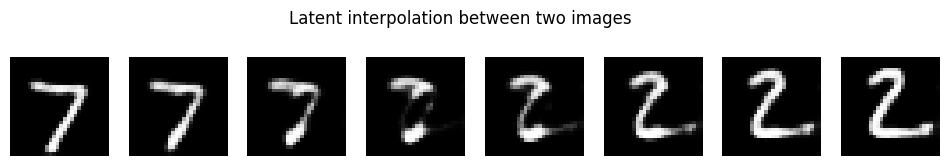


Conv Autoencoder visualizations complete.


In [9]:
# Cell: Q2 — MNIST Conv Autoencoder: DataLoader, model, training, and improved visualization
import torchvision
from torchvision import transforms, datasets

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download MNIST
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

BATCH = 128
train_loader_ae = DataLoader(mnist_train, batch_size=BATCH, shuffle=True, num_workers=0)
test_loader_ae = DataLoader(mnist_test, batch_size=BATCH, shuffle=False, num_workers=0)

# Define ConvAutoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32x7x7
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(32*7*7, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*7*7),
            nn.Unflatten(1, (32,7,7)),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16x14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out
    def encode(self, x):
        return self.encoder(x)
    def decode(self, z):
        return self.decoder(z)

# instantiate
ae = ConvAutoencoder(latent_dim=32).to(device)
print('AE params:', sum(p.numel() for p in ae.parameters() if p.requires_grad))

# Training loop for autoencoder (quick run)
criterion_ae = nn.MSELoss()
opt_ae = torch.optim.Adam(ae.parameters(), lr=1e-3)
EPOCHS_AE = 10
best_val_ae = float('inf')
for epoch in range(1, EPOCHS_AE+1):
    ae.train()
    train_loss = 0
    for xb, _ in train_loader_ae:
        xb = xb.to(device)
        opt_ae.zero_grad()
        out = ae(xb)
        loss = criterion_ae(out, xb)
        loss.backward()
        opt_ae.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_ae.dataset)
    # small validation on test subset
    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, _ in test_loader_ae:
            xb = xb.to(device)
            out = ae(xb)
            val_loss += criterion_ae(out, xb).item() * xb.size(0)
    val_loss /= len(test_loader_ae.dataset)
    print(f'AE Epoch {epoch}/{EPOCHS_AE}, Train MSE: {train_loss:.6f}, Val MSE: {val_loss:.6f}')
    if val_loss < best_val_ae:
        best_val_ae = val_loss
        torch.save({'ae_state': ae.state_dict()}, 'conv_ae_best.pth')

# Visualize reconstructions (improved layout)
ae.load_state_dict(torch.load('conv_ae_best.pth', map_location=device)['ae_state'])
ae.to(device)
ae.eval()

xb_all, yb_all = next(iter(test_loader_ae))
with torch.no_grad():
    xb_all = xb_all.to(device)
    recon_all = ae(xb_all[:16]).cpu()

n_cols = 8
fig, axes = plt.subplots(2, n_cols, figsize=(12,4))
for i in range(n_cols):
    axes[0,i].imshow(xb_all[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    axes[0,i].set_title(f'Orig {i}')
    axes[1,i].imshow(recon_all[i].squeeze(), cmap='gray')
    axes[1,i].axis('off')
    axes[1,i].set_title(f'Recon {i}')
plt.suptitle('Original (top) vs Reconstructed (bottom) — first 8 samples')
plt.tight_layout()
plt.show()

# Compute test MSE and PSNR (pixel-wise)
mse_total = 0.0
n_pixels = 0
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        out = ae(xb)
        mse_total += ((out - xb)**2).sum().item()
        n_pixels += xb.numel()
mse_pixel = mse_total / n_pixels
psnr = 10 * math.log10(1.0 / mse_pixel)
print(f'\nAE Test pixel MSE: {mse_pixel:.8f}, PSNR: {psnr:.4f} dB')

# Latent space extraction for subset and PCA visualization
from sklearn.decomposition import PCA
subset_loader = DataLoader(mnist_test, batch_size=512, shuffle=False)
images, labels = next(iter(subset_loader))
images = images.to(device)
with torch.no_grad():
    latents = ae.encode(images).cpu().numpy()
pca = PCA(n_components=2)
proj = pca.fit_transform(latents)
plt.figure(figsize=(8,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=labels.numpy(), cmap='tab10', s=8)
plt.colorbar(scatter, ticks=range(10))
plt.title('PCA of latent vectors (first 512 test images)')
plt.show()

# Interpolation between two test images in latent space (visual)
with torch.no_grad():
    img1 = xb_all[0:1].to(device)
    img2 = xb_all[1:2].to(device)
    z1 = ae.encode(img1)
    z2 = ae.encode(img2)
    n_interp = 8
    alphas = np.linspace(0,1,n_interp)
    interp_imgs = []
    for a in alphas:
        z = (1-a)*z1 + a*z2
        dec = ae.decode(z)
        interp_imgs.append(dec.cpu().squeeze().numpy())

fig, axs = plt.subplots(1, n_interp, figsize=(12,2))
for i in range(n_interp):
    axs[i].imshow(interp_imgs[i], cmap='gray')
    axs[i].axis('off')
plt.suptitle('Latent interpolation between two images')
plt.show()

print('\nConv Autoencoder visualizations complete.')
